In [1]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from collections import deque
from itertools import chain

# read in data

In [2]:
mtx_path = '/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20241225_rerun_mtx-stand_by/4.cxtri/2.mtx/shell/cxtri-bl/outs/filtered'
adata = sc.read_10x_mtx(mtx_path)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 7821 × 12802
    var: 'gene_ids', 'feature_types'

# QC

## mark mitochondrial genes

In [3]:
# mitochondrial genes
mt_genes = ('mt_ATP6', 'mt_COX1', 'mt_COX2', 'mt_COX3', 'mt_CYTB', 'mt_ND1', 'mt_ND2', 'mt_ND3', 'mt_ND4', 'mt_ND5', 'MissingGeneID')

adata.var["mt"] = adata.var_names.map(lambda x: str(x) in mt_genes)

## calculate QC metrics

In [4]:
sc.pp.calculate_qc_metrics(
    adata, inplace=True, percent_top=[20], log1p=True,
    qc_vars=["mt"],
)
adata

AnnData object with n_obs × n_vars = 7821 × 12802
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
adata.obs['pct_counts_mt'].median()

np.float32(11.318311)

## plot QC plot before do filtering 

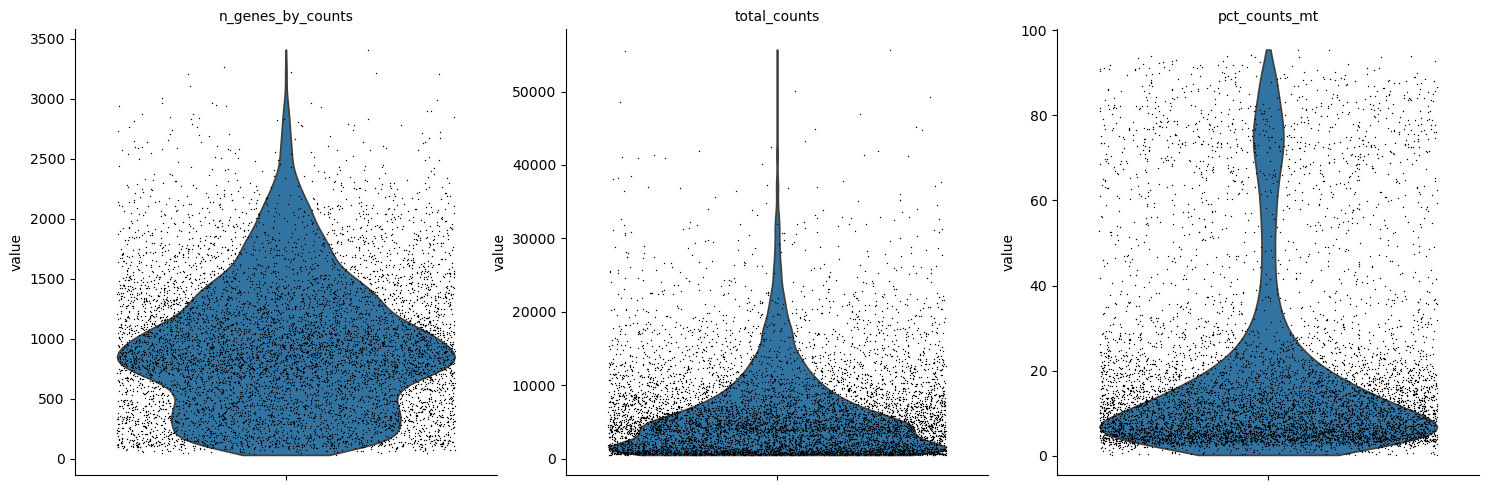

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"], # "pct_counts_mt"
    jitter=0.4,
    multi_panel=True,
)

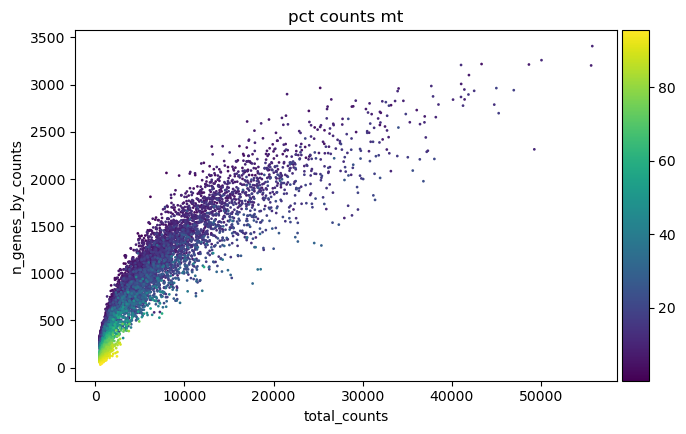

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## plot QC plot after do filtering 

In [8]:
# maximum percent.mt
max_percent_mt = 15

adata.obs["mt_outlier"] = (
    adata.obs["pct_counts_mt"] > max_percent_mt
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    4846
True     2975
Name: count, dtype: int64

In [9]:
# QC thresholds
min_n_genes_by_counts = 100
# maximum nFeature_RNA
max_n_genes_by_counts = 2500


adata.obs["genes_outlier"] = \
    (adata.obs.n_genes_by_counts < min_n_genes_by_counts) | \
    (adata.obs.n_genes_by_counts > max_n_genes_by_counts)
adata.obs.genes_outlier.value_counts()

genes_outlier
False    7617
True      204
Name: count, dtype: int64

In [10]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[
    (~adata.obs.mt_outlier) & \
    (~adata.obs.genes_outlier)
].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 7821
Number of cells after filtering of low quality cells: 4772


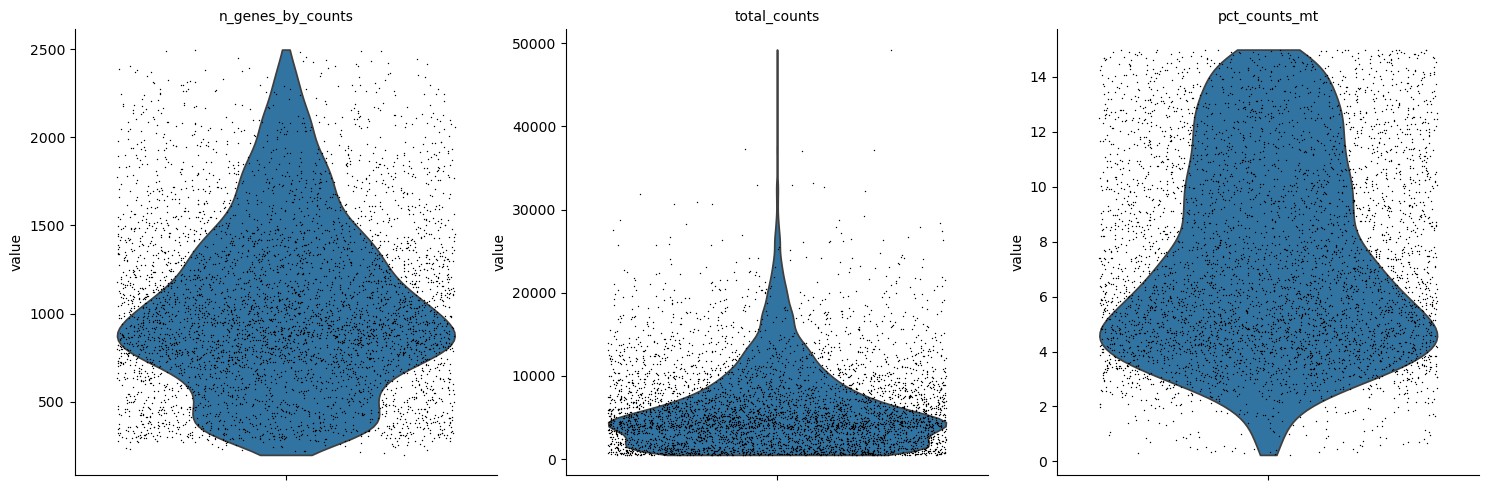

In [11]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"], # "pct_counts_mt"
    jitter=0.4,
    multi_panel=True,
)

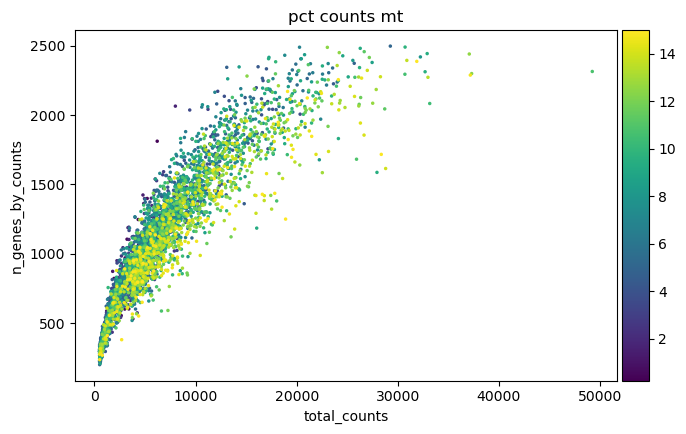

In [12]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [13]:
adata.obs.n_genes_by_counts.median()

np.float64(973.0)

In [14]:
adata.obs.total_counts.median()

np.float32(4896.5)

## write QC data for doublets check

In [15]:
Rscript = """library(dplyr)
library(Seurat)
library(ggplot2)
library(future)
library(Cairo)
library(DoubletFinder)
library(Matrix)
library(SeuratDisk)

args <- commandArgs(trailingOnly = TRUE)

## read in file --------------------------------------------------------
# path to 10x directory
ipath = args[1]
# 'project' in 'CreateSeuratObject'
project = 'midgut'
# read in file
data10x = Read10X(
    data.dir = ipath
)
# make Seurat object of RNA data
# create Seurat object
seurat_obj =  CreateSeuratObject(
    counts = data10x, 
    assay = "RNA",
    project = project, 
    min.cells = 3
)
## do normalization --------------------------------------------------------
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)
# feature selection
# Identification of highly variable features
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
# scaling data
all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes)

## PCA reduce dimension ----------------------------------------------------
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))
# runUMAP
seurat_obj <- RunUMAP(seurat_obj, dims = 1:50)

# https://cloud.tencent.com/developer/article/1825672
nExp <- round(ncol(seurat_obj) * 0.04)  # expect 4% doublets
data.filt <- doubletFinder_v3(
    seurat_obj, 
    pN = 0.25, # https://cloud.tencent.com/developer/article/1825672
    pK = 0.09, 
    nExp = nExp, 
    PCs = 1:50)

DF.name = colnames(data.filt@meta.data)[grepl("DF.classification", colnames(data.filt@meta.data))]

DimPlot(data.filt, group.by = DF.name)

# save seurat_obj
opath_seurat_obj = './mark_doublet/mark_doublet.seurat_obj.rds'
saveRDS(data.filt, file = opath_seurat_obj)
# write h5ad file
SaveH5Seurat(data.filt, filename = "./mark_doublet/mark_doublet.seurat_obj.h5Seurat")
Convert("./mark_doublet/mark_doublet.seurat_obj.h5Seurat", dest = "h5ad")
"""

In [16]:
os.mkdir('./mark_doublet')
with open('./mark_doublet/DoubletFinder.R', 'wt') as f:
    f.write(Rscript)
os.system(f'~/miniconda3/envs/hy-seurat/bin/Rscript ./mark_doublet/DoubletFinder.R {mtx_path}')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject
Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |========================================

[1] "Creating 2607 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix


[1] "Scaling data..."


  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Creating h5Seurat file for version 3.1.5.9900
Adding counts for RNA
Adding data for RNA
Adding scale.data for RNA
Adding variable features for RNA
Adding feature-level metadata for RNA
Adding cell embeddings for pca
Adding loadings for pca
No projected loadings for pca
Adding standard deviations for pca
No JackStraw data for pca
Adding cell embeddings for umap
No loadings for umap
No projected loadings for umap
No standard deviations for umap
No JackStraw data for umap
Validating h5Seurat file
Adding scale.data from RNA as X
Transfering meta.features to var
Adding data from RNA as raw
Transfering meta.features to raw/var
Transfering meta.data to obs
Adding dimensional reduction information for pca
Adding feature loadings for pca
Adding dimensional reduction information for umap


0

## remove doublets

In [17]:
# read in data marked doublets
dblets = sc.read('./mark_doublet/mark_doublet.seurat_obj.h5ad')
dblets

AnnData object with n_obs × n_vars = 7821 × 9666
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pANN_0.25_0.09_313', 'DF.classifications_0.25_0.09_313'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [18]:
# remove doublets
dblets_col = [i for i in dblets.obs.columns if i.startswith('DF.classifications_')][0]
sglets_obs = dblets.obs[dblets.obs[dblets_col] == 'Singlet'].index
adata = adata[adata.obs.index.isin(sglets_obs)]
adata

View of AnnData object with n_obs × n_vars = 4535 × 12802
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## save AnnData after QC

In [19]:
# save data
adata.write("1.QC.h5ad")
# show AnnData
adata

View of AnnData object with n_obs × n_vars = 4535 × 12802
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

# Normalization

In [2]:
# read in data
adata = sc.read('./1.QC.h5ad')
adata

AnnData object with n_obs × n_vars = 4535 × 12802
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [3]:
# normalization 
sc.pp.normalize_total(
    adata, 
    target_sum=1e6, 
    exclude_highly_expressed=True
)
# Logarithmize
sc.pp.log1p(adata)

# show AnnData
adata

AnnData object with n_obs × n_vars = 4535 × 12802
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [4]:
# save data
adata.write("2.normalization.h5ad")

# Feature Selection

In [5]:
# read in data
adata = sc.read('./2.normalization.h5ad')
adata

AnnData object with n_obs × n_vars = 4535 × 12802
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [6]:
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=4000, 
    flavor='seurat_v3'
)
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)
# show AnnData
adata

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 4535 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [7]:
# save data
adata.write("3.after_feature_selection.h5ad")

# dimensional reduction

In [8]:
# read in data
adata = sc.read('./3.after_feature_selection.h5ad')
adata

AnnData object with n_obs × n_vars = 4535 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


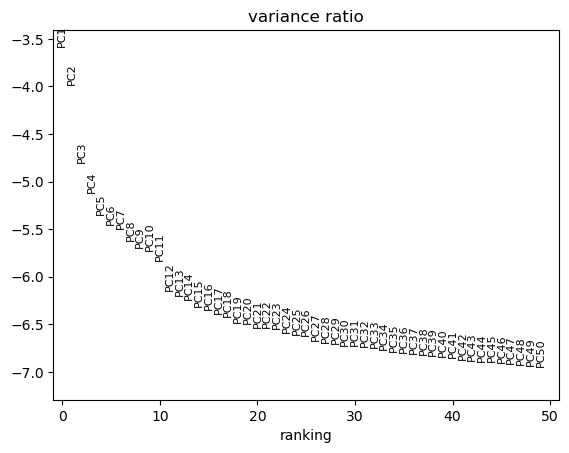

In [9]:
# run PCA
sc.pp.pca(adata, svd_solver="auto", use_highly_variable=True)
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

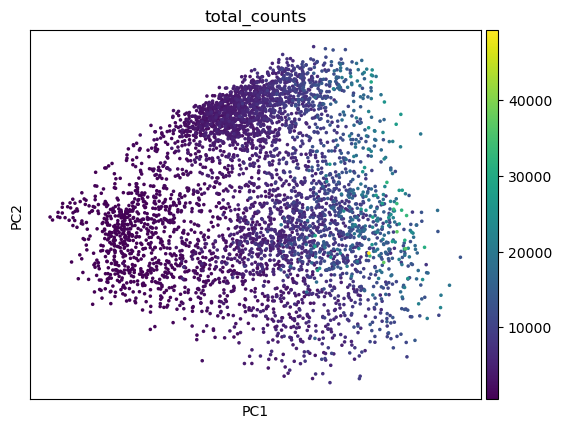

In [10]:
sc.pl.pca_scatter(adata, color="total_counts")

In [11]:
# save data
adata.write("4.PCA.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 4535 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# clustering

In [12]:
# read in data
adata = sc.read('./4.PCA.h5ad')
adata

AnnData object with n_obs × n_vars = 4535 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## plot UMAP

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_52261/2706160960.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


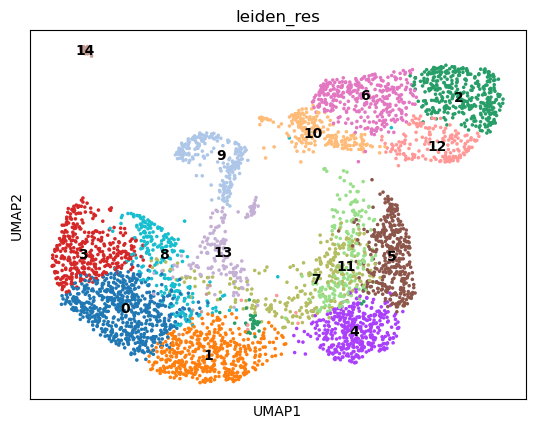

In [13]:
adata = sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30, copy=True)
sc.tl.umap(
    adata, 
    min_dist=0.3
)
sc.tl.leiden(
    adata, 
    key_added="leiden_res", 
    resolution=1.2,
)
sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

In [14]:
adata.obs['leiden_res'].value_counts()

leiden_res
0     635
1     446
2     413
3     388
4     388
5     378
6     342
7     263
8     235
9     235
10    226
11    200
12    175
13    160
14     51
Name: count, dtype: int64

In [15]:
# save data
adata.write("5.cluster.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 4535 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden_res', 'leiden_res_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Annotation

In [3]:
# read in data
adata = sc.read('./5.cluster.h5ad')
adata

AnnData object with n_obs × n_vars = 4535 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden_res', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## make marker genes dict (Culex pipiens pallens)

In [4]:
aae_homo = pd.read_csv('/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20240830_homo_gene/cxtri_aae.homog.csv')
aae_homo

,cxtri,aae
0,Ctri05375,LOC110673977
1,Ctri05761,LOC110673980
2,Ctri12482,LOC110673981
3,Ctri03408,LOC110673983
4,Ctri02287,LOC110673984
...,...,...
9152,Ctri05472,LOC5580326
9153,Ctri05473,LOC5580327
9154,Ctri05470,LOC5580329
9155,Ctri05866,LOC5580330


In [5]:
marker_genes_raw = {
    'ISC/EB': ['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC5580247'], # fibulin-1, Klu, Delta, esg, LYSC11, PCNA , 'LOC110676293', 'LOC5580247'
    'Cardia': ['LOC5564993', 'LOC5572257'], # GAM1, LYZ1 ['LOC5568253', 'LOC5572257'] FCN3, CTRB2 'LOC5579458', 
    'EC': ['LOC23687865', 'LOC5573855'], # Nub, CPA-VII 'LOC5573855', 
    'EC-like': ['LOC5574806', 'LOC5570613'], # CAH7, Cht10, SNAT1, LYZL 'LOC5571803', 
    'EE': ['LOC5575988', 'LOC5569132', 'LOC5575886', 'LOC5573874'], # prospero, orcokinin, npf, Calexcitin-1
    'VM':['LOC5571832'], # actin
    'FBC':['LOC5571084'], # apolipophorin-3
    'HC':['LOC5570883', 'LOC110674010'], # LRIM16, NimB2
}

In [6]:
mg_homo = []
for k, v in marker_genes_raw.items():
    print(f'{k}:')
    for g in v:
        res = aae_homo[aae_homo['aae'] == g]
        if res.empty:
            print(f'{g}: NA')
        else:
            print(res)
            mg_homo.append(res)
mg_homo = pd.concat(mg_homo, axis=0)
mg_homo = dict(mg_homo.iloc[:, [1,0]].values)
mg_homo

ISC/EB:
         cxtri         aae
979  Ctri08281  LOC5563695
          cxtri         aae
8290  Ctri05145  LOC5578162
          cxtri         aae
9066  Ctri06068  LOC5580156
          cxtri         aae
4373  Ctri04136  LOC5570443
          cxtri         aae
9117  Ctri05970  LOC5580247
Cardia:
LOC5564993: NA
          cxtri         aae
5308  Ctri06126  LOC5572257
EC:
         cxtri          aae
872  Ctri03519  LOC23687865
LOC5573855: NA
EC-like:
          cxtri         aae
6660  Ctri09069  LOC5574806
          cxtri         aae
4454  Ctri01811  LOC5570613
EE:
          cxtri         aae
7233  Ctri01973  LOC5575988
LOC5569132: NA
LOC5575886: NA
          cxtri         aae
6162  Ctri02594  LOC5573874
VM:
          cxtri         aae
5090  Ctri09277  LOC5571832
FBC:
          cxtri         aae
4713  Ctri11444  LOC5571084
HC:
LOC5570883: NA
        cxtri           aae
21  Ctri04212  LOC110674010


{'LOC5563695': 'Ctri08281',
 'LOC5578162': 'Ctri05145',
 'LOC5580156': 'Ctri06068',
 'LOC5570443': 'Ctri04136',
 'LOC5580247': 'Ctri05970',
 'LOC5572257': 'Ctri06126',
 'LOC23687865': 'Ctri03519',
 'LOC5574806': 'Ctri09069',
 'LOC5570613': 'Ctri01811',
 'LOC5575988': 'Ctri01973',
 'LOC5573874': 'Ctri02594',
 'LOC5571832': 'Ctri09277',
 'LOC5571084': 'Ctri11444',
 'LOC110674010': 'Ctri04212'}

In [7]:
marker_genes = {}
for k, v in marker_genes_raw.items():
    marker_genes[k] = [mg_homo[i] for i in v if i in mg_homo.keys()]

marker_genes['EC-like'] = ['Ctri09069', 'Ctri09956', 'Ctri09123', 'Ctri01811']
marker_genes['EE'] += ['Ctri04723', 'Ctri05940', 'Ctri07102']

marker_genes

{'ISC/EB': ['Ctri08281', 'Ctri05145', 'Ctri06068', 'Ctri04136', 'Ctri05970'],
 'Cardia': ['Ctri06126'],
 'EC': ['Ctri03519'],
 'EC-like': ['Ctri09069', 'Ctri09956', 'Ctri09123', 'Ctri01811'],
 'EE': ['Ctri01973', 'Ctri02594', 'Ctri04723', 'Ctri05940', 'Ctri07102'],
 'VM': ['Ctri09277'],
 'FBC': ['Ctri11444'],
 'HC': ['Ctri04212']}

In [8]:
g_n = {mg_homo[k]: v \
    for k, v in zip(['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC5564993', 'LOC5579458', 'LOC23687865', 'LOC5573855', 'LOC5571803', 'LOC5574806', 'LOC5570613', 'LOC110676293', 'LOC5575988', 'LOC5575886', 'LOC5569132', 'LOC5573874', 'LOC5571832', 'LOC5571084', 'LOC5570883', 'LOC110674010', 'LOC5580247', 'LOC110676249', 'LOC5572376', 'LOC5572257', 'LOC5565599'],
    ['fibulin-1', 'Klu', 'Delta', 'esg', 'GAM1', 'LYSC', 'Nubbin', 'CPA-VII', 'CAH7', 'Cht10', 'SNAT1', 'LYSC11', 'prospero', 'npf', 'orcokinin', 'Calexcitin-1', 'actin', 'apolipophorin-3', 'LRIM16', 'NimB2', 'PCNA', 'CG1139', 'BTBD3', 'chymotrypsin-2', 'CCHa2']) if k in mg_homo.keys()
}
g_n

{'Ctri08281': 'fibulin-1',
 'Ctri05145': 'Klu',
 'Ctri06068': 'Delta',
 'Ctri04136': 'esg',
 'Ctri03519': 'Nubbin',
 'Ctri09069': 'Cht10',
 'Ctri01811': 'SNAT1',
 'Ctri01973': 'prospero',
 'Ctri02594': 'Calexcitin-1',
 'Ctri09277': 'actin',
 'Ctri11444': 'apolipophorin-3',
 'Ctri04212': 'NimB2',
 'Ctri05970': 'PCNA',
 'Ctri06126': 'chymotrypsin-2'}

In [9]:
g_n.update(
    {
        'Ctri04723': 'SCG5', # Neuroendocrine protein 7B2 precursor (Secretogranin V) c9 EE
        'Ctri09956': 'KLK7', # Belongs to the peptidase S1 family c7 EC-like
        'Ctri05940': 'CABP', # calcium-binding protein c16 EE
        'Ctri07102': 'FGB/G', # Fibrinogen beta and gamma chains, C-terminal globular domain c14 EE
        'Ctri09123': 'MAP7', # MAP7 (E-MAP-115) family c10 EC-like
    }
)
g_n

{'Ctri08281': 'fibulin-1',
 'Ctri05145': 'Klu',
 'Ctri06068': 'Delta',
 'Ctri04136': 'esg',
 'Ctri03519': 'Nubbin',
 'Ctri09069': 'Cht10',
 'Ctri01811': 'SNAT1',
 'Ctri01973': 'prospero',
 'Ctri02594': 'Calexcitin-1',
 'Ctri09277': 'actin',
 'Ctri11444': 'apolipophorin-3',
 'Ctri04212': 'NimB2',
 'Ctri05970': 'PCNA',
 'Ctri06126': 'chymotrypsin-2',
 'Ctri04723': 'SCG5',
 'Ctri09956': 'KLK7',
 'Ctri05940': 'CABP',
 'Ctri07102': 'FGB/G',
 'Ctri09123': 'MAP7'}

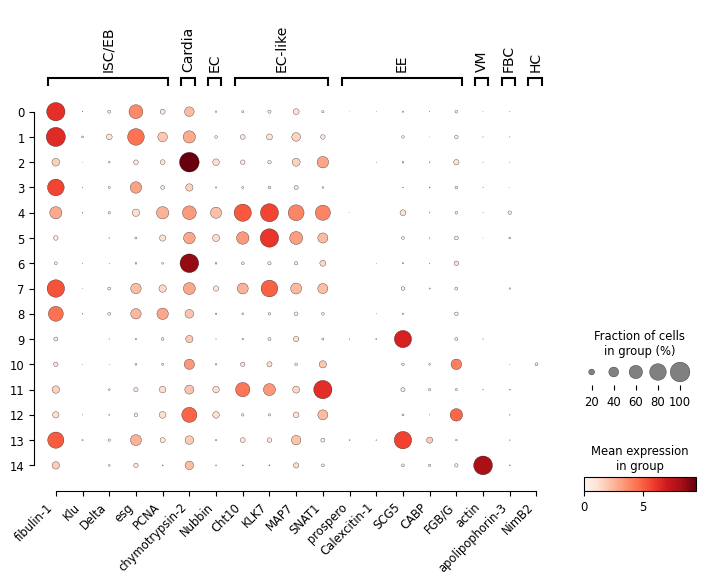

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='leiden_res',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)

In [11]:
n_id = {
    'ISC/EB': ['0', '3'],
    'ISC/EB-prol': ['1', '8'],
    'Cardia-1': ['2', '6'],
    # 'Cardia-2': ['6'],
    'EC': ['4', '5'],
    'EC-like-1': ['7'],
    'EC-like-2': ['11'],
    # 'EC-like-3': ['12'],
    'EE-1': ['9', '13'],
    'EE-2': ['10', '12'],
    # 'EE-3': ['11'],
    'VM': ['14'],
    # 'HC': ['16'],
}

In [12]:
sorted([int(i) for i in chain(*[i for i in n_id.values()]) if i != ''])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [13]:
id_n = {}
for k, v in n_id.items():
    for i in v:
        id_n[i] = k

id_n

{'0': 'ISC/EB',
 '3': 'ISC/EB',
 '1': 'ISC/EB-prol',
 '8': 'ISC/EB-prol',
 '2': 'Cardia-1',
 '6': 'Cardia-1',
 '4': 'EC',
 '5': 'EC',
 '7': 'EC-like-1',
 '11': 'EC-like-2',
 '9': 'EE-1',
 '13': 'EE-1',
 '10': 'EE-2',
 '12': 'EE-2',
 '14': 'VM'}

In [14]:
adata.obs['cluster'] = adata.obs['leiden_res'].map(
    lambda x: id_n[x] if x in id_n.keys() else x)

In [15]:
adata.obs['cluster'].unique()

array(['Cardia-1', 'ISC/EB', 'EC', 'ISC/EB-prol', 'EE-2', 'VM',
       'EC-like-1', 'EC-like-2', 'EE-1'], dtype=object)

In [16]:
adata.obs['cluster_name'] = adata.obs['cluster']
adata.obs['cluster_name'] = adata.obs['cluster_name'].astype('category')
adata.obs['cluster_name'] = adata.obs[
        'cluster_name'
    ].cat.reorder_categories(list(n_id.keys()), ordered=True)

adata.obs['cluster_name'].unique()

['Cardia-1', 'ISC/EB', 'EC', 'ISC/EB-prol', 'EE-2', 'VM', 'EC-like-1', 'EC-like-2', 'EE-1']
Categories (9, object): ['ISC/EB' < 'ISC/EB-prol' < 'Cardia-1' < 'EC' ... 'EC-like-2' < 'EE-1' < 'EE-2' < 'VM']

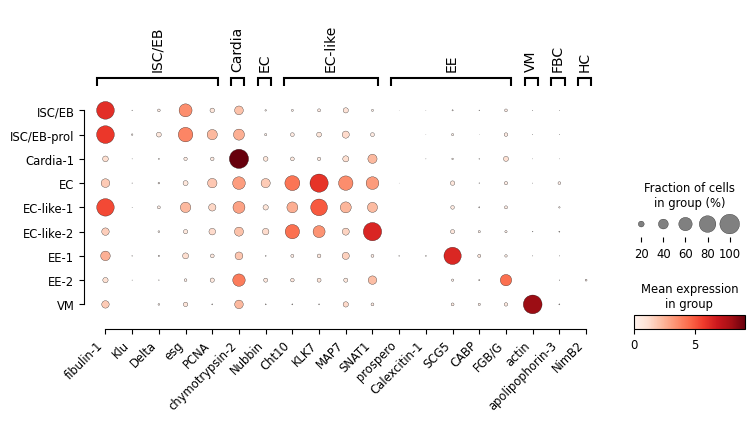

In [17]:
# save fig
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib.use('cairo')

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)
# plt.savefig('aae_dotplot.pdf', bbox_inches='tight')
# plt.close()

In [78]:
sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

In [79]:
sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
)

In [80]:
adata.uns['rank_genes_groups.wilcoxon']

{'params': {'groupby': 'cluster_name',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'pts':              ISC/EB  ISC/EB-prol  Cardia-1  Cardia-2        EC  EC-like-1  \
 Ctri00001  0.000000     0.000000  0.000000  0.000000  0.000000   0.002950   
 Ctri00002  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000   
 Ctri00003  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000   
 Ctri00004  0.235005     0.548463  0.288184  0.152968  0.596481   0.268437   
 Ctri00005  0.039331     0.101655  0.063401  0.011416  0.092669   0.056047   
 ...             ...          ...       ...       ...       ...        ...   
 mt_ND1     0.548673     0.855792  0.785303  0.509132  0.988270   0.914454   
 mt_ND2     0.559489     0.867612  0.744957  0.431507  0.967155   0.890855   
 mt_ND3     0.777778     0.983452  0.889049  0.737443  0.995308   0.941003   
 mt_ND4     0.838741     0.992908  0.893372  0.7191

In [81]:
name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg

,pvals_adj,logfoldchanges,scores,pts,pts_rest,leiden_res
names,,,,,,
Ctri01877,3.123907e-26,18.144136,11.312123,1.000000,0.005450,VM
Ctri01462,3.123907e-26,18.055265,11.311933,1.000000,0.007811,VM
Ctri00566,3.123907e-26,18.182127,11.311837,1.000000,0.002725,VM
Ctri03184,3.123907e-26,17.983715,11.311741,1.000000,0.003996,VM
Ctri09377,3.123907e-26,14.536715,11.306389,1.000000,0.055223,VM
...,...,...,...,...,...,...
Ctri04165,6.338059e-05,1.076261,4.571095,0.305476,0.225793,Cardia-1
Ctri10484,6.512866e-05,1.303685,4.564964,0.255043,0.173259,Cardia-1
Ctri02402,9.469132e-05,1.052939,4.483873,0.302594,0.227235,Cardia-1


In [82]:
markg.to_csv('./5.marker_genes.csv')

In [18]:
n_id = {
    'ISC/EB': ['0', '3'],
    'ISC/EB-prol': ['1', '8'],
    'Cardia-1': ['2', '6'],
    # 'Cardia-2': ['6'],
    'EC': ['4', '5'],
    'EC-like-1': ['7'],
    'EC-like-2': ['11'],
    # 'EC-like-3': ['12'],
    'EE-1': ['9', '13'],
    'EE-2': ['10', '12'],
    # 'EE-3': ['11'],
    'VM': ['14'],
    # 'HC': ['16'],
}

In [19]:
id_n = {}
for k, v in n_id.items():
    for i in v:
        id_n[i] = k

id_n

{'0': 'ISC/EB',
 '3': 'ISC/EB',
 '1': 'ISC/EB-prol',
 '8': 'ISC/EB-prol',
 '2': 'Cardia-1',
 '6': 'Cardia-1',
 '4': 'EC',
 '5': 'EC',
 '7': 'EC-like-1',
 '11': 'EC-like-2',
 '9': 'EE-1',
 '13': 'EE-1',
 '10': 'EE-2',
 '12': 'EE-2',
 '14': 'VM'}

In [20]:
adata.obs['cluster'] = adata.obs['leiden_res'].map(
    lambda x: id_n[x] if x in id_n.keys() else x)

In [21]:
adata.obs['cluster'].unique()

array(['Cardia-1', 'ISC/EB', 'EC', 'ISC/EB-prol', 'EE-2', 'VM',
       'EC-like-1', 'EC-like-2', 'EE-1'], dtype=object)

In [22]:
adata.obs['cluster_name'] = adata.obs['cluster']
adata.obs['cluster_name'] = adata.obs['cluster_name'].astype('category')
adata.obs['cluster_name'] = adata.obs[
        'cluster_name'
    ].cat.reorder_categories(list(n_id.keys()), ordered=True)

adata.obs['cluster_name'].unique()

['Cardia-1', 'ISC/EB', 'EC', 'ISC/EB-prol', 'EE-2', 'VM', 'EC-like-1', 'EC-like-2', 'EE-1']
Categories (9, object): ['ISC/EB' < 'ISC/EB-prol' < 'Cardia-1' < 'EC' ... 'EC-like-2' < 'EE-1' < 'EE-2' < 'VM']

In [38]:
adata.write('./6.ann.h5ad')

In [8]:
adata = sc.read('./6.ann.h5ad')

In [23]:
# save fig
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.use('cairo')

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)
plt.savefig('cxtri_dotplot.pdf', bbox_inches='tight')
plt.close()

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))

# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#8B008B", "#00CED1", "#FF4500"]
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'VM', 'FBC', 'HC']

umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 4.5; y = 1

ax.arrow(
    x-6.5, y-3, 0, 3, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-5.5, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-1.5, 'UMAP-2', ha='right', va='center', rotation=90)

for i, (cell, color) in enumerate(grp_color.items()):
    x = -2; y = 14
    sep = 7
    j = i // sep

    ax.plot(x + j * 4, y - (i % sep) * 0.6, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 4 + 0.5, y - (i % sep) * 0.6, 
    f'{cell}: {len(adata.obs[adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
plt.savefig('cxtri_umap.pdf', bbox_inches='tight')
plt.close()

In [2]:
adata = sc.read('./6.ann.h5ad')

In [3]:
sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
)

name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg.to_csv('./5.marker_genes.csv')